In [6]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Download data
start_date = '1990-01-01'
end_date = '1999-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)

# Compute log returns
sp500_data = sp500_data[['Close']].dropna()
sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data.dropna(inplace=True)

# Add month column for grouping
sp500_data['Month'] = sp500_data.index.month

# Detect outliers using 3-sigma rule
mean = sp500_data['Log Return'].mean()
std = sp500_data['Log Return'].std()
threshold = 3
outliers = np.abs(sp500_data['Log Return'] - mean) > threshold * std

# Monthly average returns
monthly_avg_returns = sp500_data.groupby('Month')['Log Return'].mean()

# Print outliers and replacement values
print("Outliers and their replacements:\n")
for idx in sp500_data[outliers].index:
    date = idx.strftime('%Y-%m')
    original = sp500_data.loc[idx, 'Log Return']
    month = sp500_data.loc[idx, 'Month']
    replacement = monthly_avg_returns.loc[month]
    print(f"{date}: original={original:.4f}, replacement={replacement:.4f}")

# Replace outliers with monthly average
def replace_with_monthly_avg(row):
    if outliers.loc[row.name]:
        return monthly_avg_returns.loc[row['Month']]
    return row['Log Return']

sp500_data['Log Return'] = sp500_data.apply(replace_with_monthly_avg, axis=1)

# Drop helper column
sp500_data.drop(columns=['Month'], inplace=True)

[*********************100%***********************]  1 of 1 completed

Outliers and their replacements:

1998-08: original=-0.1576, replacement=-0.0238


In [24]:
sp500_data

Price,Close,Log Return
Date,,
1990-02-01,331.890015,0.008503
1990-03-01,339.940002,0.023966
1990-04-01,330.799988,-0.027255
1990-05-01,361.230011,0.088001
1990-06-01,358.019989,-0.008926
...,...,...
1999-08-01,1320.410034,-0.006274
1999-09-01,1282.709961,-0.028967
1999-10-01,1362.930054,0.060662


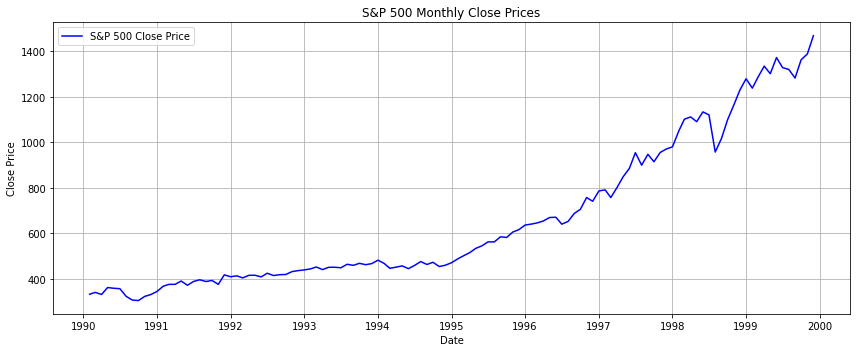

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

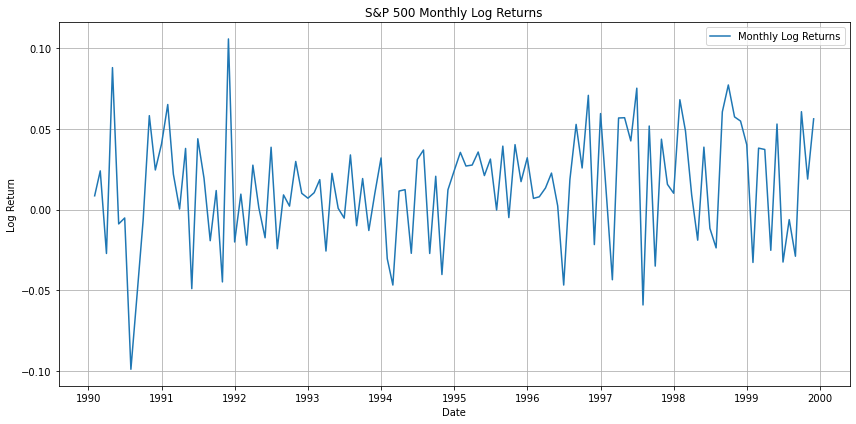

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

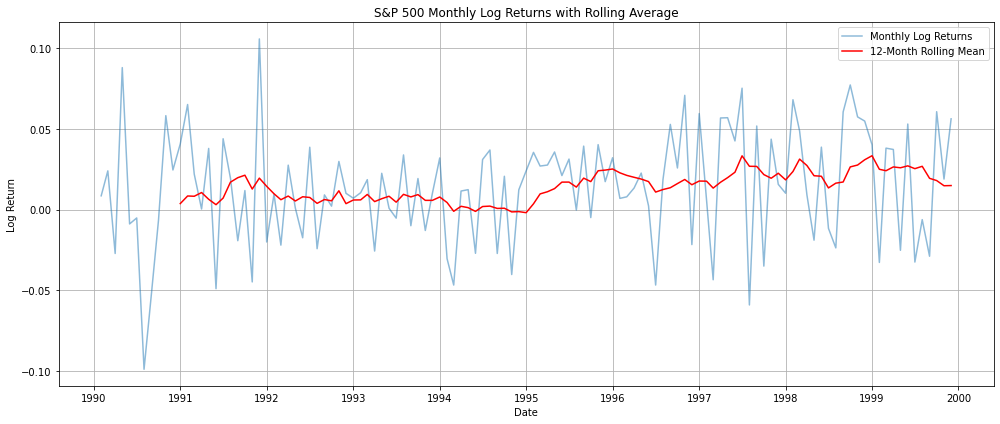

In [27]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

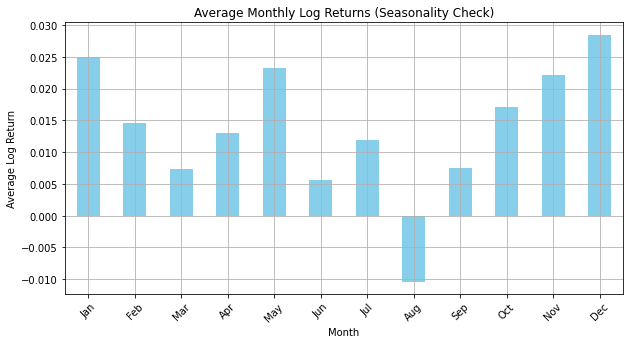

In [28]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

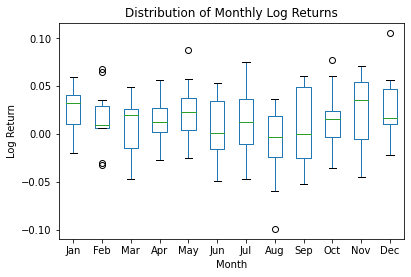

In [29]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [30]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -11.917847
p-value: 0.000000
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


**Analysis:**

The ADF test statistic of -11.933 and the p-value of 0.000 both indicate that the null hypothesis of a unit root can be rejected with strong confidence. This supports the conclusion that the time series is stationary, meaning it does not show a trend or non-stationary behavior.

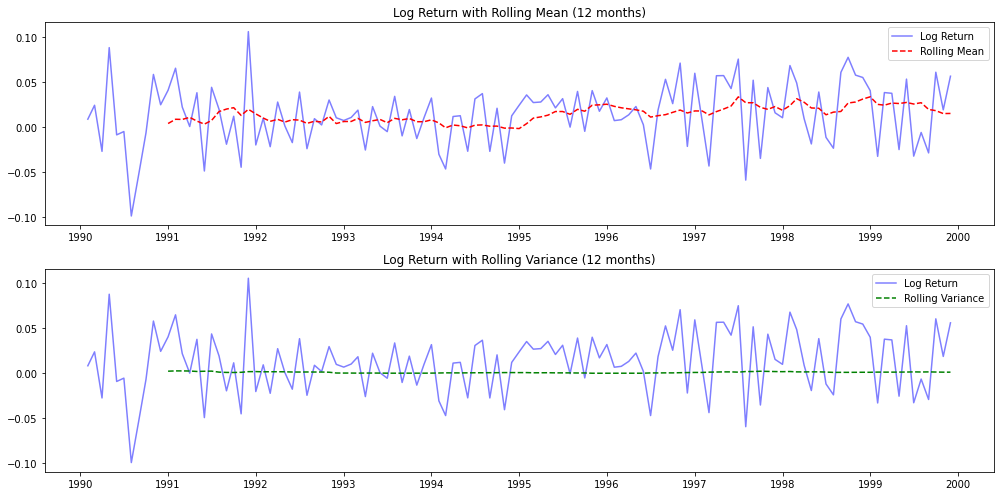

In [31]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

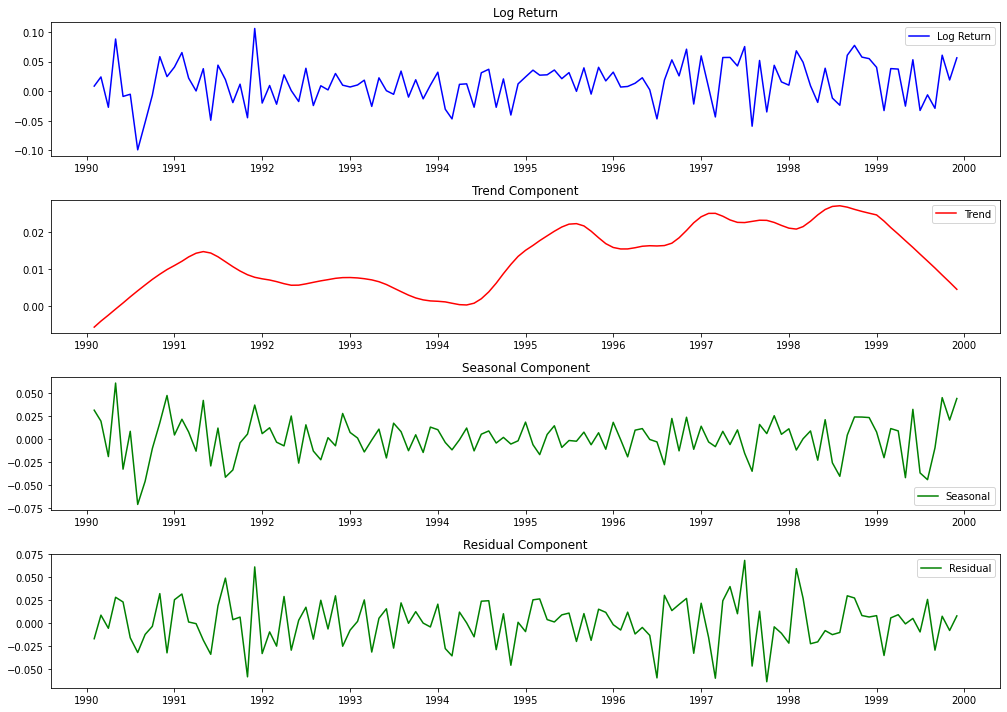

In [32]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 231.898
Date:                Sun, 04 May 2025   AIC                           -455.797
Time:                        23:08:28   BIC                           -444.680
Sample:                    02-01-1990   HQIC                          -451.283
                         - 12-01-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.003      4.601      0.000       0.008       0.020
ar.L1         -0.5792      0.434     -1.335      0.182      -1.429       0.271
ma.L1          0.4562      0.46

/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Analysis:**

* Constant (const): 0.0137 — statistically significant (p < 0.001), indicates positive average monthly return.

* AR(1): -0.5792 — not significant (p = 0.182), suggests weak autoregressive structure.

* MA(1): 0.4562 — not significant (p = 0.322), MA component also weak.

* sigma²: 0.0012 — variance of residuals; significant and low, suggesting low volatility

In [36]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.87234D+00    |proj g|=  3.92947D-01

At iterate    5    f= -1.87324D+00    |proj g|=  1.11146D+00

At iterate   10    f= -1.88942D+00    |proj g|=  4.18359D-01

At iterate   15    f= -1.89061D+00    |proj g|=  3.98665D-03

At iterate   20    f= -1.89076D+00    |proj g|=  2.27391D-01

At iterate   25    f= -1.89172D+00    |proj g|=  7.17308D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   

**Analysis:**

* Seasonal AR(12) = 0.8210 (p = 0.002): Indicates strong positive correlation with returns from the same month in the previous year, suggesting annual seasonality or market cycles.

* Seasonal MA(12) = -0.6626 (p = 0.039): Reflects mean-reverting behavior to past shocks from 12 months ago, meaning extreme events tend to be followed by corrections a year later.

* σ² = 0.0013 (p < 0.001): The model’s residual variance is low and statistically significant, indicating reliable and stable model performance.

In [37]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9107
Date:                Sun, 04 May 2025   Prob (F-statistic):              0.533
Time:                        23:12:14   Log-Likelihood:                 235.90
No. Observations:                 119   AIC:                            -447.8
Df Residuals:                     107   BIC:                            -414.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

* Low explanatory power: R² = 0.086, Adj. R² = -0.008 → months explain almost none of the variance in log returns.

* Only August (month 8) is significant: Coefficient = -0.0355 (p = 0.030) → log returns tend to be lower in August.

* Model diagnostics look clean: Residuals are roughly normal (Jarque-Bera p = 0.462), no autocorrelation (Durbin-Watson = 2.28).

/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: Valu

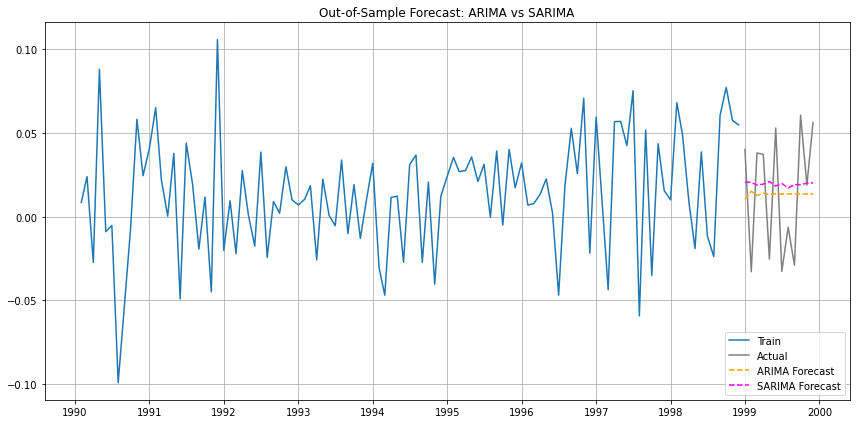

In [38]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

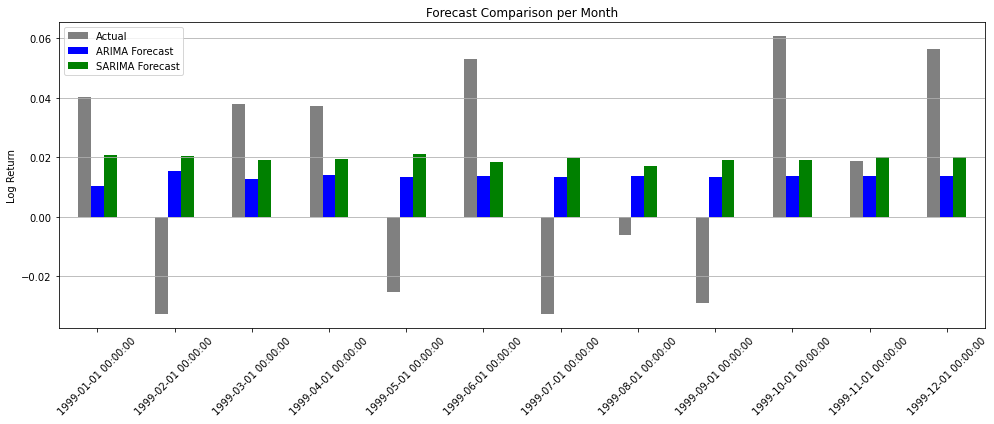

In [39]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

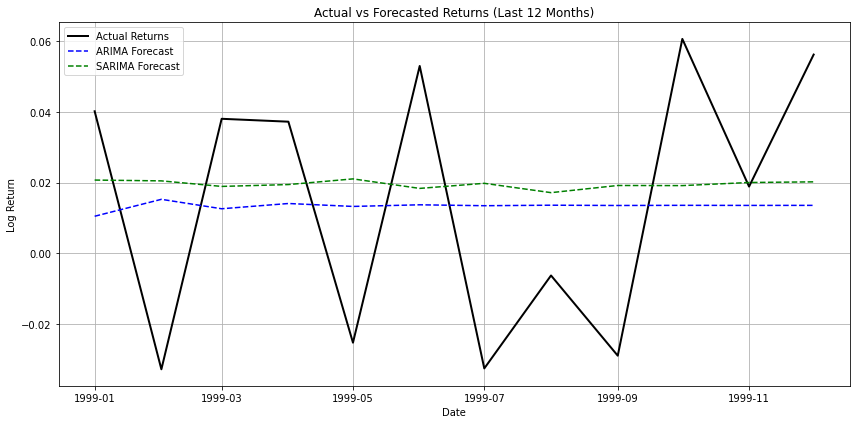

In [40]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.03398
ARIMA RMSE: 0.03628

SARIMA MAE: 0.03278
SARIMA RMSE: 0.03638


**Analysis:**

SARIMA slightly outperforms ARIMA in MAE (0.03278 vs. 0.03398), indicating better average error, but ARIMA has a lower RMSE (0.03628 vs. 0.03638), suggesting fewer large errors — overall, both models perform similarly with a slight edge to SARIMA in consistency.

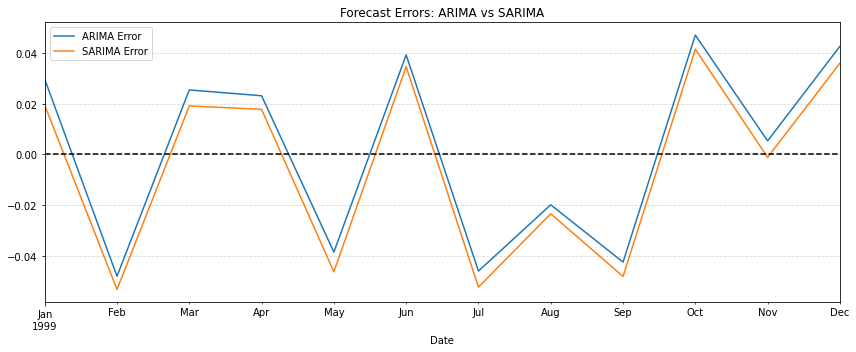

In [42]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()